## Importações

In [196]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error

plt.style.use('seaborn')

## Leitura dos dados

In [197]:
## lendo os dados das lojas 

lojas = pd.read_csv('data/stores.csv')
lojas.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [198]:
## lendo as vendas de cada loja

vendas = (
    pd.read_csv('data/transactions.csv')
    .assign(date = lambda x: pd.to_datetime(x.date))
    .query("date >= '2017-01-01'")
    .reset_index(drop=True)
)

vendas.head()

,date,store_nbr,transactions
0,2017-01-01,25,1642
1,2017-01-02,1,516
2,2017-01-02,2,2083
3,2017-01-02,3,3918
4,2017-01-02,4,1682


## Analisando os dados

In [199]:
JANELA = 30

In [200]:
dados_plot = (
    vendas
    .query("store_nbr == 25")
    .sort_values('date')
    .drop('store_nbr',axis=1)
    .set_index('date')
)

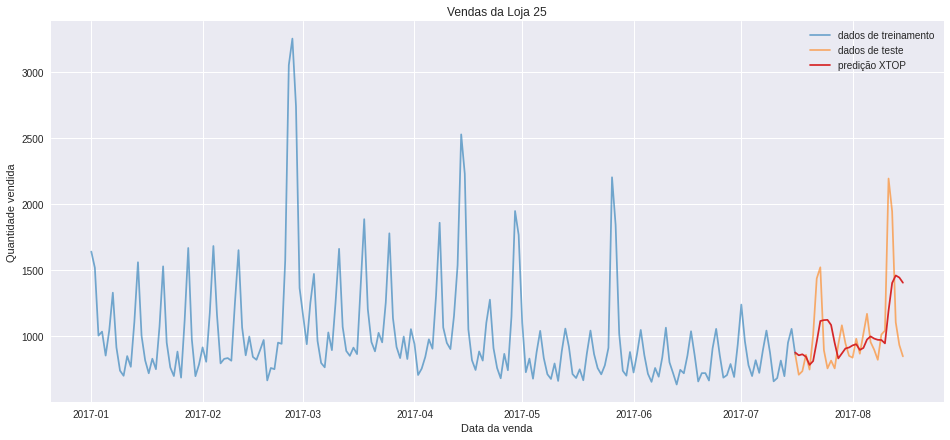

In [202]:
f, ax = plt.subplots(figsize=(16,7))

ax.plot(dados_plot[:-JANELA],color='tab:blue',alpha=0.6,label='dados de treinamento')
ax.plot(dados_plot[-JANELA -1:],color='tab:orange',alpha=0.6,label='dados de teste')
ax.plot(dados_plot.rolling(5).mean()[-JANELA -1:],color='tab:red',label='predição XTOP')

ax.set_title('Vendas da Loja 25')
ax.set_xlabel('Data da venda')
ax.set_ylabel('Quantidade vendida')

plt.legend()
plt.show()

In [222]:
rmse_xtop = np.sqrt(mean_squared_error(dados_plot[-JANELA -1:].values,dados_plot.rolling(5).mean()[-JANELA -1:].values))

print(f'RMSE XTOP : {round(rmse_xtop,2)}')

RMSE XTOP : 307.15


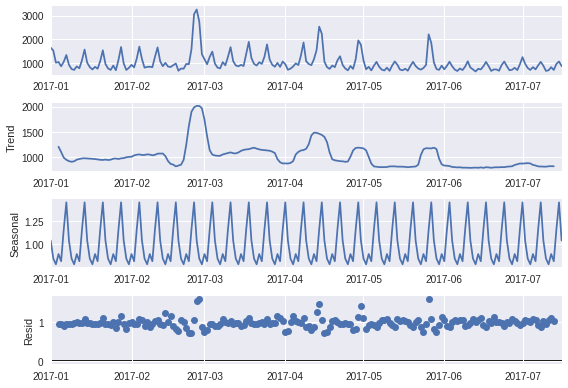

In [175]:
seasonal_decompose(dados_plot[:-JANELA],model='multiplicative').plot();

## Engenharia de Features

In [117]:
dados = (
    dados_plot
    .assign(cos_month = lambda x: np.cos(2*math.pi*x.index.month.values / 12))
    .assign(cos_day_of_month = lambda x: np.cos(2*math.pi*x.index.day.values / 31))
    .assign(cos_day_of_week = lambda x: np.cos(2*math.pi*x.index.dayofweek.values / 7))
    .assign(sin_month = lambda x: np.sin(2*math.pi*x.index.month.values / 12))
    .assign(sin_day_of_month = lambda x: np.sin(2*math.pi*x.index.day.values / 31))
    .assign(sin_day_of_week = lambda x: np.sin(2*math.pi*x.index.dayofweek.values / 7))
    .assign(lag_mean_minus_3 = lambda x: x.transactions.rolling(3).mean())
    .assign(lag_mean_minus_5 = lambda x: x.transactions.rolling(5).mean())
    .assign(lag_mean_minus_7 = lambda x: x.transactions.rolling(7).mean())
    .dropna()
)

![](https://miro.medium.com/max/700/1*7Y-jyZsaXraHq9IUOVXUBQ.gif)

## Preparação dos dados

In [161]:
x = dados.drop('transactions',axis=1)
y = dados.transactions

x_train, x_test = x[:-JANELA], x[-JANELA-1:]
y_train, y_test = y[:-JANELA], y[-JANELA-1:]

In [162]:
columns_to_scale = ['lag_mean_minus_3','lag_mean_minus_5','lag_mean_minus_7']

scaler = make_column_transformer(
    ( MinMaxScaler(feature_range=(-1,1)), columns_to_scale),
    remainder='passthrough')

In [163]:
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Treinamento e avaliação do modelo

In [215]:
model = RandomForestRegressor(n_estimators=1000,random_state=42)
model.fit(x_train_scaled,y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [216]:
y_pred = model.predict(x_test_scaled)

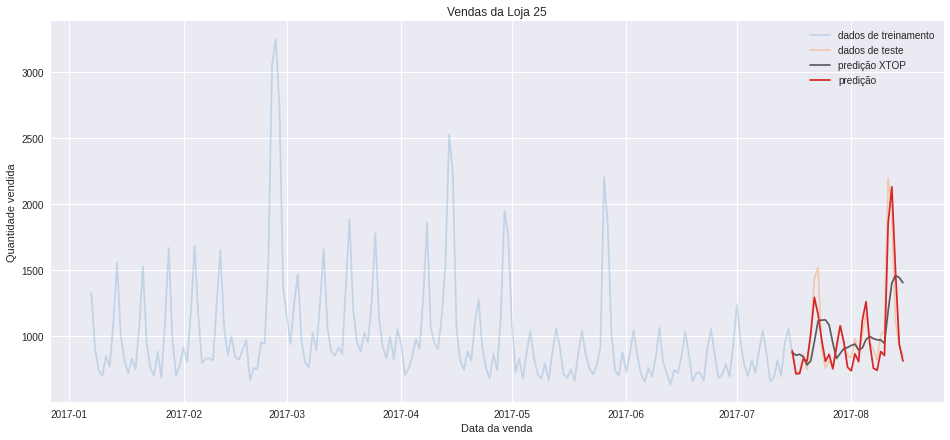

In [231]:
f, ax = plt.subplots(figsize=(16,7))

pred_df = pd.DataFrame(y_test).assign(pred_values = y_pred).assign(error = lambda x: x.transactions - x.pred_values)

ax.plot(dados[:-JANELA].transactions,color='tab:blue',alpha=0.2,label='dados de treinamento')
ax.plot(dados[-JANELA -1:].transactions,color='tab:orange',alpha=0.3,label='dados de teste')
ax.plot(dados_plot.rolling(5).mean()[-JANELA -1:],color='black',label='predição XTOP',alpha=0.6)
ax.plot(pred_df.pred_values,color='tab:red',label='predição')


ax.set_title('Vendas da Loja 25')
ax.set_xlabel('Data da venda')
ax.set_ylabel('Quantidade vendida')

plt.legend()
plt.show()

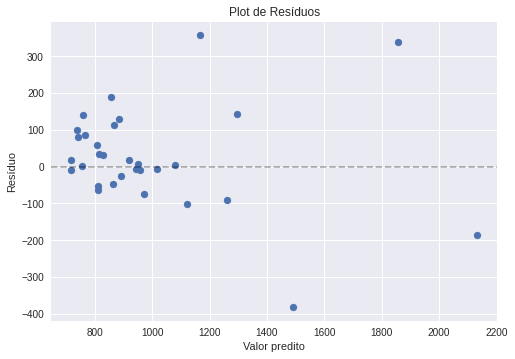

In [218]:
f, ax = plt.subplots()

plt.scatter(pred_df.pred_values,pred_df.error)
ax.axhline(0,c='black',ls='--',alpha=0.3)
ax.set_xlabel('Valor predito')
ax.set_ylabel('Resíduo')
ax.set_title('Plot de Resíduos')
plt.show()

In [242]:
rmse_modelo = np.sqrt(mean_squared_error(y_test,y_pred))

print(f'RMSE XTOP       : {round(rmse_xtop,2)}')
print(f'RMSE MODELO     : {round(rmse_modelo,2)}')
print(f'REDUÇÃO DO ERRO : {round((rmse_xtop-rmse_modelo)/rmse_xtop*100,2)}%')

RMSE XTOP       : 307.15
RMSE MODELO     : 138.1
REDUÇÃO DO ERRO : 55.04%
